# Description

Goals of the notebook:
- Generate a high dimensional dataset using sklearn
- Use the algorithm to learn representations on that
- Benchmark with MBDL

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import json
import numpy as np
import torch
import hydra
import scipy.linalg as la
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
from tqdm import tqdm, trange
from src.plot_utils import scatter_plot_2d
from src.utils import sparsity_measure
from omegaconf import OmegaConf
from torchvision.utils import make_grid
from pprint import pprint
from torch.utils.data import TensorDataset, DataLoader
from pathlib import Path
from datetime import datetime
from sklearn.decomposition import MiniBatchDictionaryLearning, SparseCoder, DictionaryLearning
from sklearn.metrics import r2_score
from sklearn.cluster import KMeans

In [6]:
sns.set_style('ticks')
sns.set_context("paper", font_scale=1.0, rc={"text.usetex": True})
sns.set_palette("colorblind")
sns.set_style({"font.family": "serif", "font.serif": ["Times New Roman"]})

In [5]:
project_dir = Path('/n/home13/shubham/Current Projects/bioplausible_learning/code')

In [7]:
with hydra.initialize(version_base=None, config_path="../../../configs"):
    cfg = hydra.compose(config_name='ksm_high_dim.yaml')
    exp_params = OmegaConf.to_container(cfg, resolve=True)
    

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

exp_params['device'] = 'device'

# figfolder = Path(f'../../results/simulated/highdim/{datetime.now().strftime("%m-%d")}/{datetime.now().strftime("%H-%M")}')
# os.makedirs(figfolder, exist_ok=True)    
pprint(exp_params)    

{'dataset': {'batch_size': 128,
             'dim': 30,
             'n_samples': 1500,
             'name': 'highdim'},
 'device': 'device',
 'model': {'K': 16,
           'Winit': 'Kmeans',
           'lam': 0.5,
           'omega': 0.0001,
           'perturbation': 0.1,
           'rho': 1.0,
           'sparsity': 0.125},
 'optimizer': {'Minit': 'zero',
               'latent_iters': 15,
               'log_interval': 5,
               'lrs': {'Z': 0.01,
                       'Z_decay': 0.9,
                       'interval': 10,
                       'params': 0.01},
               'max_epochs': 3000,
               'param_iters': 1,
               'vis_interval': 20}}


Simulated data generated from a tall dictionary

In [8]:
from sklearn.datasets import make_sparse_coded_signal

def get_sim_data(n_samples, n_components, n_features, n_nonzero_coefs, max_correlation=0.3, noise=None, seed=42):
    
    np.random.seed(seed)
    positions = np.random.randint(0, high=n_components, size=(n_samples, n_nonzero_coefs))
    vals = 5 + (-1)*np.random.rand(n_samples, n_nonzero_coefs)
    Z = np.zeros((n_samples, n_components))
    Z[np.arange(n_samples)[:, None], positions] = vals
    
    # Create D with max correlation
    # random_matrix = 2*(max_correlation) * np.random.rand(n_components, n_components) - max_correlation
    # lower_triangle = np.tril(random_matrix, k=0)
    # print(lower_triangle)
    # cov = lower_triangle @ lower_triangle.T + np.eye(n_components)
                                   
    # cov = random_matrix + random_matrix.T
    
    cov = np.eye(n_components)
    # np.fill_diagonal(cov, 1)
    
    D = np.random.multivariate_normal(np.zeros(n_components), cov, size=n_features).T
    # print(np.linalg.norm(D, axis=1, keepdims=True))
    D /= np.linalg.norm(D, axis=1, keepdims=True)
    X = Z @ D
    
    
    
    # X, D, Z = make_sparse_coded_signal(n_samples=n_samples, n_components=n_components, n_features=n_features, n_nonzero_coefs=n_nonzero_coefs, random_state=seed)
    
    if noise is not None:
        # Adding Gaussian Noise
        X += noise * np.random.randn(*X.shape)    
    
    return torch.from_numpy(X).float(), torch.from_numpy(D).float(), torch.from_numpy(Z).float()


X, D, Z = get_sim_data(n_samples=exp_params['dataset']['n_samples'],
                       n_components=exp_params['model']['K'],
                       n_features=exp_params['dataset']['dim'],
                       n_nonzero_coefs=np.ceil(exp_params['model']['K']*exp_params['model']['sparsity']).astype(int),
                       seed=42)

# Create pytorch dataset and dataloader
indices = torch.arange(X.shape[0])
dataset = TensorDataset(X, indices)
dataloader = DataLoader(dataset, batch_size=exp_params['dataset']['batch_size'], )

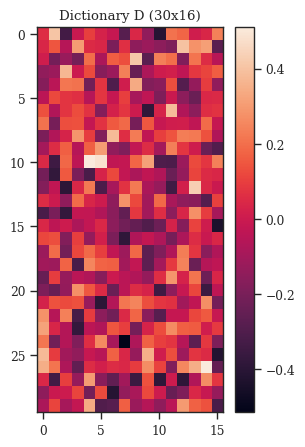

In [9]:
# Visualize dictionary D with colorbar
fig, ax = plt.subplots(1, 1, figsize=(3, 5))
im = ax.imshow(D.T, aspect='auto')
ax.set_title(f'Dictionary D ({D.shape[1]}x{D.shape[0]})')
ax.grid(False)
fig.colorbar(im, ax=ax, orientation='vertical')
plt.show()

In [10]:
print("Max correlation between columns")
print(f"Max: {torch.max(torch.abs(D @ D.T - torch.eye(D.shape[0]))):.2f}")

Max correlation between columns
Max: 0.48


### Run benchmarks with DL
- Initialize the model with KMeans

In [11]:
X.shape, D.shape, Z.shape

(torch.Size([1500, 30]), torch.Size([16, 30]), torch.Size([1500, 16]))

In [12]:
# Compute Cluster centers for the given data
kmeans = KMeans(n_clusters=exp_params['model']['K'], random_state=42).fit(X)
W_init = kmeans.cluster_centers_
W_init /= np.linalg.norm(W_init, axis=1, keepdims=True)

# sim_lam = 2*exp_params['model']['lam']
# print(sim_lam)
coder = SparseCoder(dictionary=W_init, transform_alpha=exp_params['model']['lam'], transform_algorithm='lasso_lars')
Z_init = coder.transform(X.numpy())

/n/home13/shubham/.conda/envs/representations/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


#### Using Standard Dictionary Learning

In [13]:
synthetic_dict = DictionaryLearning(n_components=exp_params['model']['K'], 
                                    alpha=exp_params['model']['lam'], 
                                    random_state=42, 
                                    dict_init=W_init,
                                    code_init=Z_init,
                                    max_iter=2500,
                                    transform_algorithm='lasso_lars',
                                    verbose=True)

synthetic_dict.fit(X.numpy())

[dict_learning] ........................


DictionaryLearning(alpha=0.5,
                   code_init=array([[ 0.        ,  0.        ,  0.        , ...,  3.61522844,
         0.65898088,  0.        ],
       [ 0.        ,  2.83037375,  0.73799577, ...,  0.        ,
        -0.01139655,  0.        ],
       [ 0.        , -0.6543224 , -0.86112468, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [-0.25007485, -0.29449839,  0.        , ...,  0.        ,
         0.        ,  4.16775445],
       [ 3.31702128, -1.31060486,  4.36949645, ...,  0.        ,
         0.        , -0.35281527],
       [ 0.        , -1.98205933,  0.12083417, ...,  0.        ,
         0.        ,  0.        ]]),
                   dict_init=array([[-...
        -0.11978154, -0.03403598, -0.11281483,  0.27252183, -0.06807254,
         0.18317996, -0.14159201,  0.21591389,  0.073701  ,  0.00293902,
        -0.30809135, -0.09566123,  0.13688185, -0.08195065, -0.10059739,
        -0.0523479 ,  0.27989454,  0.18072781, -0.07597222, -0.10818784,
         0.00684555,  0.29912672, -0.39219496, -0.15932807, -0.07766967]]),
                   max_iter=2500, n_components=16, random_state=42,
                   transform_algorithm='lasso_lars', verbose=True)

In [12]:
# Save estimated dictionary
folder = project_dir / 'data/simulated/'
filename = f"learnt_normal_dict_K{exp_params['model']['K']}_lam{exp_params['model']['lam']:.2e}_n{exp_params['dataset']['dim']}.pkl"
os.makedirs(folder, exist_ok=True)
save_data = {'obj': synthetic_dict, 'Z': Z, 'X': X}
with open(folder/filename, 'wb') as f:
    pickle.dump(save_data, f)

#### Load dictionary learning

In [13]:
filename = f"learnt_normal_dict_K{exp_params['model']['K']}_lam{exp_params['model']['lam']:.2e}_n{exp_params['dataset']['dim']}.pkl"
folder = project_dir / 'data/simulated/'
with open(folder / filename, 'rb') as f:
    data = pickle.load(f)
    synthetic_dict = data['obj']
    Z = data['Z']
    X = data['X']

In [14]:
def compute_reconstruction_error(X, D, Z):
    """
    Compute the reconstruction error of the given data
    X: (n_samples, n_features)
    D: (n_components, n_features)
    Z: (n_samples, n_components)
    """
    prediction = Z @ D
    error = np.mean(np.linalg.norm(X - prediction, axis=1)**2)
    return error

In [14]:
# Print the r2 score
Z_est = synthetic_dict.transform(X)
r2 = r2_score(X, Z_est @ synthetic_dict.components_)
print(f"R2 Score: {r2:0.4f}")

# Calculate sparsity level
# sparsity = np.mean(np.sum(Z_est != 0, axis=1)) / exp_params['model']['K']
sparsity = sparsity_measure(torch.from_numpy(Z_est))
print(f"Sparsity level: {sparsity:0.2f}")

synthetic_dict_output ={
    'D': torch.from_numpy(synthetic_dict.components_).float(),
    'Z': torch.from_numpy(Z_est).float(),
}

R2 Score: 0.9847
Sparsity level: 0.90


In [15]:
def visualize_latents(Z_vals, num_samples=5, ax=None, seed=42, **kwargs):
    
    # Set figure width and height based on number of samples
    fig_width = 5
    fig_height = 3 * num_samples
    if ax is None:
        fig, ax = plt.subplots(num_samples, 1, figsize=(fig_width, fig_height))
        
    np.random.seed(seed)
    idx = np.random.choice(Z_vals.shape[0], num_samples, replace=False)
    
    for i, idx in enumerate(idx):
        ax[i].stem(np.abs(Z_vals[idx]), **kwargs)
        ax[i].set_title(f'Sample {idx}')
        # ax[i].grid(False)
        
    return ax
   

In [16]:
from src.utils import realign_dictionaries

[ 9  1  0 13  2 12 14  3 15  4  8  5  6 10 11  7]


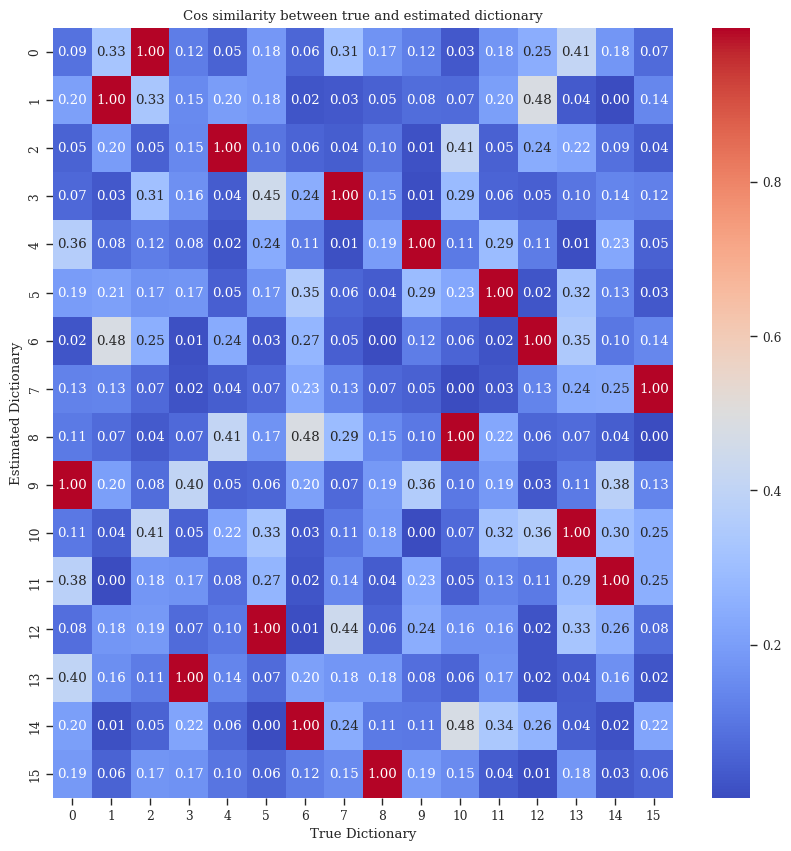

In [17]:
# Align dictionaries
cos_sim = np.abs(synthetic_dict.components_ @ D.numpy().T)
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
sns.heatmap(cos_sim, ax=ax, cmap='coolwarm', annot=True, fmt='.2f')
ax.set_title('Cos similarity between true and estimated dictionary')
ax.set_xlabel('True Dictionary')
ax.set_ylabel('Estimated Dictionary')
fig.show()

positions = realign_dictionaries(cos_sim)
print(positions)

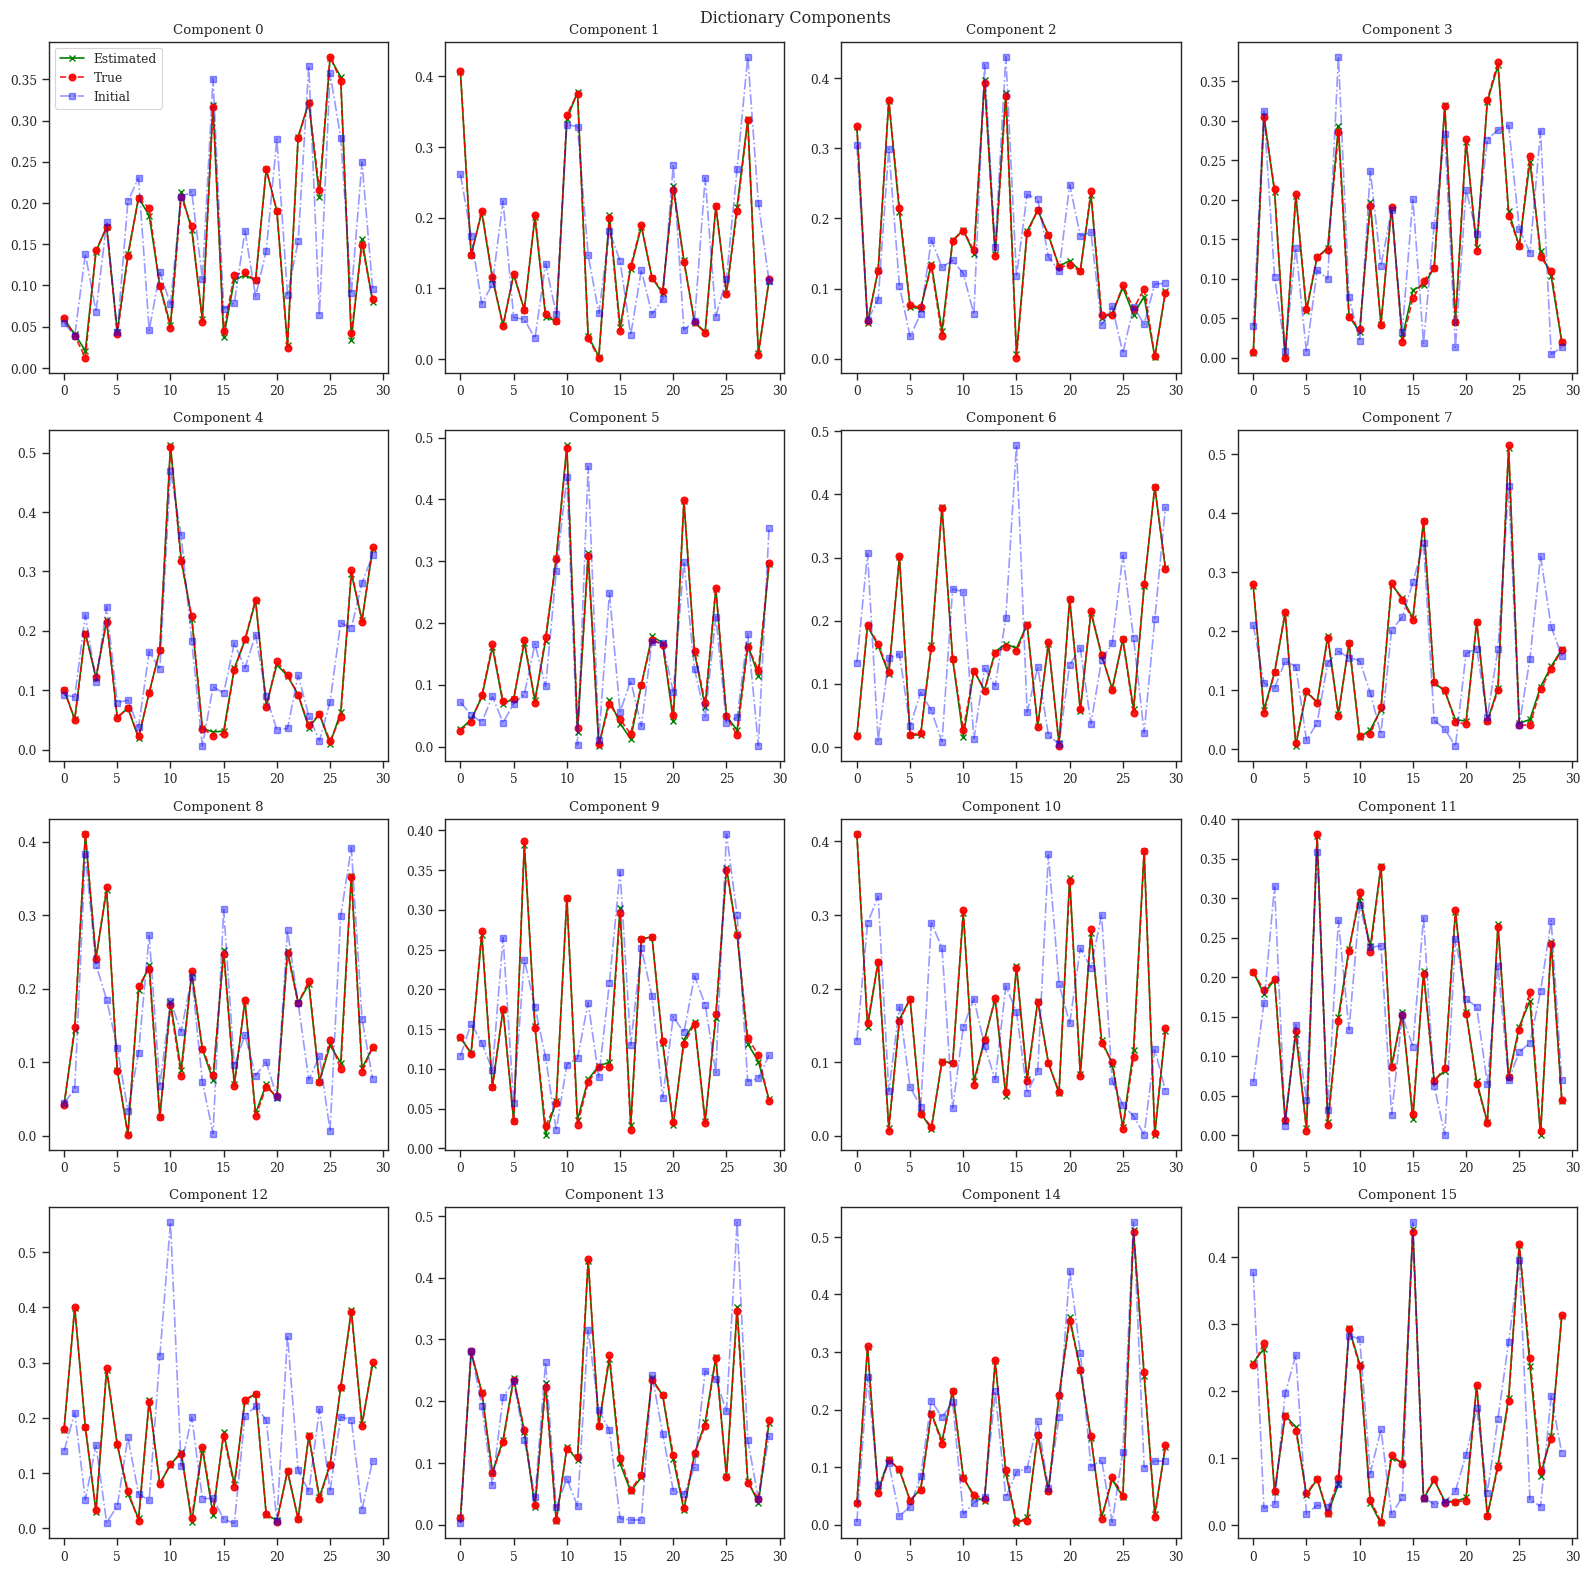

In [18]:
# Plot the dictionary
D_est_realigned = synthetic_dict.components_[positions]
W_init_realigned = W_init[positions]
n_rows = 4
n_cols = D.shape[0] // n_rows
fig, ax = plt.subplots(n_rows, n_cols, figsize=(4*n_cols, 4*n_rows))
ax = ax.ravel()
for i in range(ax.shape[0]):
    ax[i].plot(np.abs(D_est_realigned[i]), label='Estimated', c='g', linestyle='-', marker='x')
    ax[i].plot(np.abs(D[i]), label='True', c='r', linestyle='--', marker='o', alpha=0.9)
    ax[i].plot(np.abs(W_init_realigned[i]), label='Initial', c='b', linestyle='-.', marker='s', alpha=0.4)
    # ax[i].plot(D[i], label='True')
    # ax[i].plot(W_init_realigned[i], label='KMeans')
    ax[i].set_title(f'Component {i}')
ax[0].legend()
fig.suptitle('Dictionary Components')
fig.tight_layout()
fig.show()

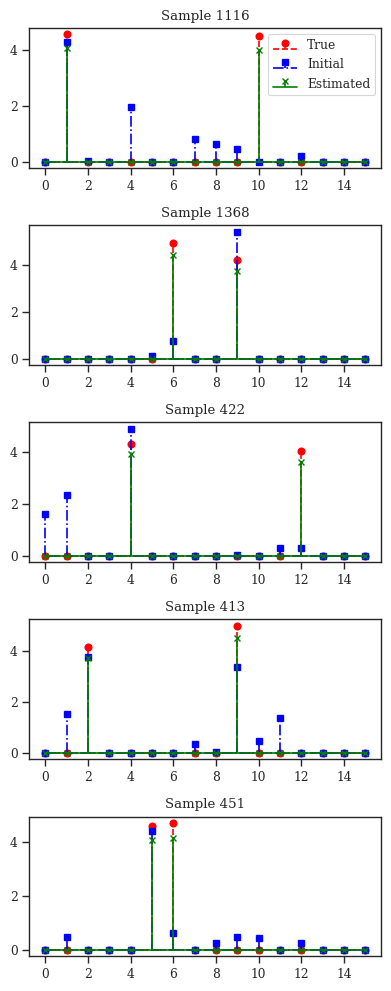

In [19]:
true_Z = Z.numpy()
fig, ax = plt.subplots(5, 1, figsize=(4, 10))
ax = visualize_latents(true_Z, ax=ax, seed=42, linefmt='r--', markerfmt='ro', basefmt='r--', label='True')
ax = visualize_latents(Z_init[:, positions], ax=ax, seed=42, linefmt='b-.', markerfmt='bs', basefmt='b-.', label='Initial')
ax = visualize_latents(Z_est[:, positions], ax=ax, seed=42, linefmt='g-', markerfmt='gx', basefmt='g-', label='Estimated')

ax[0].legend()
fig.tight_layout()
fig.show()

In [22]:
# Compute similarity
from src.run_utils import compute_similarity
similarity = compute_similarity(torch.abs(torch.from_numpy(true_Z)), torch.abs(torch.from_numpy(Z_est[:, positions])))
print(f"Zsim: {similarity:0.2f}")

d_similarity = compute_similarity(torch.abs(D), torch.abs(torch.from_numpy(synthetic_dict.components_[positions])))
print(f"Dsim: {d_similarity:0.2f}")


Zsim: 1.00
Dsim: 1.00


#### Running benchmarks with MBDL

In [23]:
num_epochs = 100

In [24]:
synthetic_dict_mbdl = MiniBatchDictionaryLearning(n_components=exp_params['model']['K'],
                                           batch_size=exp_params['dataset']['batch_size'],
                                           alpha=exp_params['model']['lam']*5,
                                           random_state=42,
                                           dict_init=W_init,
                                           transform_algorithm='lasso_lars',
                                           verbose=1
                                           )

n_updates = 0
reconst_error = []
pbar = tqdm(range(0, num_epochs))

for epoch in pbar:
    for batch in dataloader:
        X_batch, _ = batch
        # X_batch = X_batch.to(device)
        
            
        synthetic_dict_mbdl.partial_fit(X_batch.numpy())
        

    # Z_est = dict_learner.transform(X)
    # reconst_error.append(compute_reconstruction_error(X, dict_learner.components_, Z_est))
    # pbar.set_postfix_str(f"Loss: {reconst_error[-1]:0.4f}")

100%|██████████| 100/100 [00:32<00:00,  3.09it/s]


In [25]:
# Save dictionary value
folder = project_dir / 'data/simulated/'
filename = f"mb_learnt_normal_dict_K{exp_params['model']['K']}_lam{exp_params['model']['lam']:.2e}_n{exp_params['dataset']['dim']}_epochs{num_epochs}.pkl"
os.makedirs(folder, exist_ok=True)
save_data = {'obj': synthetic_dict_mbdl, 'Z': Z, 'X': X}
with open(folder/filename, 'wb') as f:
    pickle.dump(save_data, f)

In [26]:
# Load dictionary value
filename = f"mb_learnt_normal_dict_K{exp_params['model']['K']}_lam{exp_params['model']['lam']:.2e}_n{exp_params['dataset']['dim']}_epochs{num_epochs}.pkl"

folder = project_dir /  'data/simulated/'
with open(folder / filename, 'rb') as f:
    data = pickle.load(f)
    synthetic_dict_mbdl = data['obj']
    Z = data['Z']
    X = data['X']

In [27]:
# Print the r2 score
Z_est_mb = synthetic_dict_mbdl.transform(X)
r2_mb = r2_score(X, Z_est_mb @ synthetic_dict_mbdl.components_)
print(f"R2 Score: {r2_mb:0.4f}")

# Calculate sparsity level
# sparsity_mb = np.mean(np.sum(Z_est_mb != 0, axis=1)) / exp_params['model']['K']
sparsity_mb = sparsity_measure(torch.from_numpy(Z_est_mb))
print(f"Sparsity level: {sparsity_mb:0.2f}")

synthetic_dict_output_mb = {
    'D': torch.from_numpy(synthetic_dict_mbdl.components_).float(),
    'Z': torch.from_numpy(Z_est_mb).float(),
}

R2 Score: 0.9847
Sparsity level: 0.90


[ 9  1  0 13  2 12 14  3 15  4  8  5  6 10 11  7]


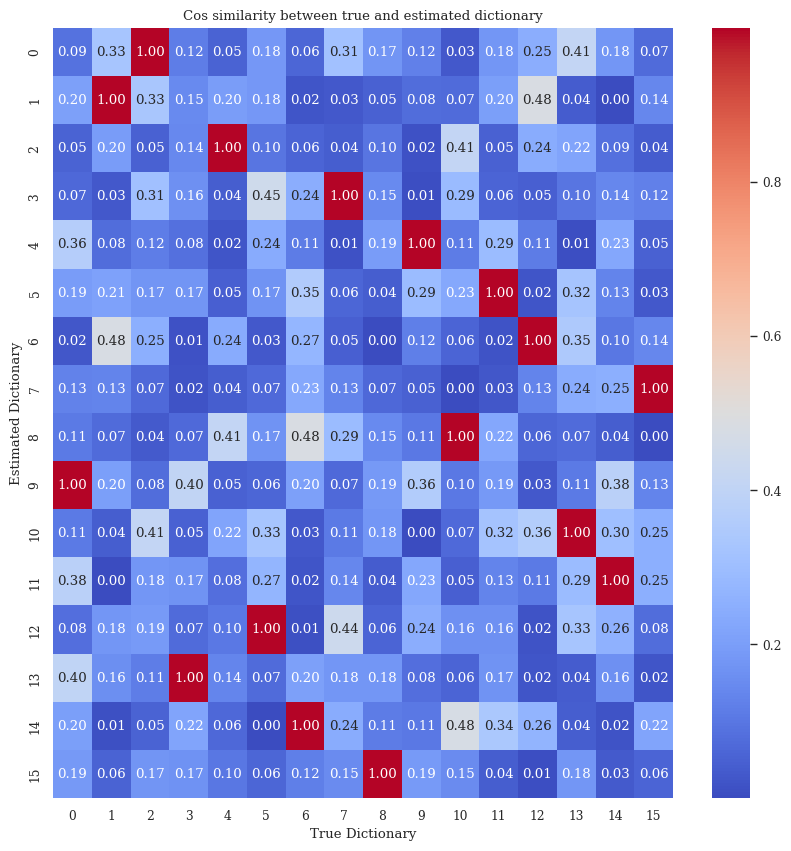

In [28]:
# Align dictionaries
cos_sim_mb = np.abs(synthetic_dict_mbdl.components_ @ D.numpy().T)
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
sns.heatmap(cos_sim_mb, ax=ax, cmap='coolwarm', annot=True, fmt='.2f')
ax.set_title('Cos similarity between true and estimated dictionary')
ax.set_xlabel('True Dictionary')
ax.set_ylabel('Estimated Dictionary')
fig.show()

positions_mb = realign_dictionaries(cos_sim_mb)
print(positions_mb)
# positions_mb = np.ones(D.shape[0], dtype=int) * (-1)
# # print(positions_mb)
# indices = set(np.arange(D.shape[0]))
# print(indices)
# # Tie occurs
# for i in range(len(positions_mb)):
#     t = np.argmax(cos_sim_mb[:, i])
#     if cos_sim_mb[t, i] == np.max(cos_sim_mb[t, :]):
#         positions_mb[i] = t
#         indices.remove(t)

# print(positions_mb)

# # Assign the remaining indices to the positions with value -1 based on the largest remaining value
# for i in range(len(positions_mb)):
#     if positions_mb[i] == -1:
#         pos = np.max(cos_sim_mb[np.array(list(indices)), i])
#         # find this pos in the given column of cos_sim_mb
#         t = np.where(cos_sim_mb[:, i] == pos)[0][0]
#         positions_mb[i] = t
#         indices.remove(t)
        
# print(positions_mb)

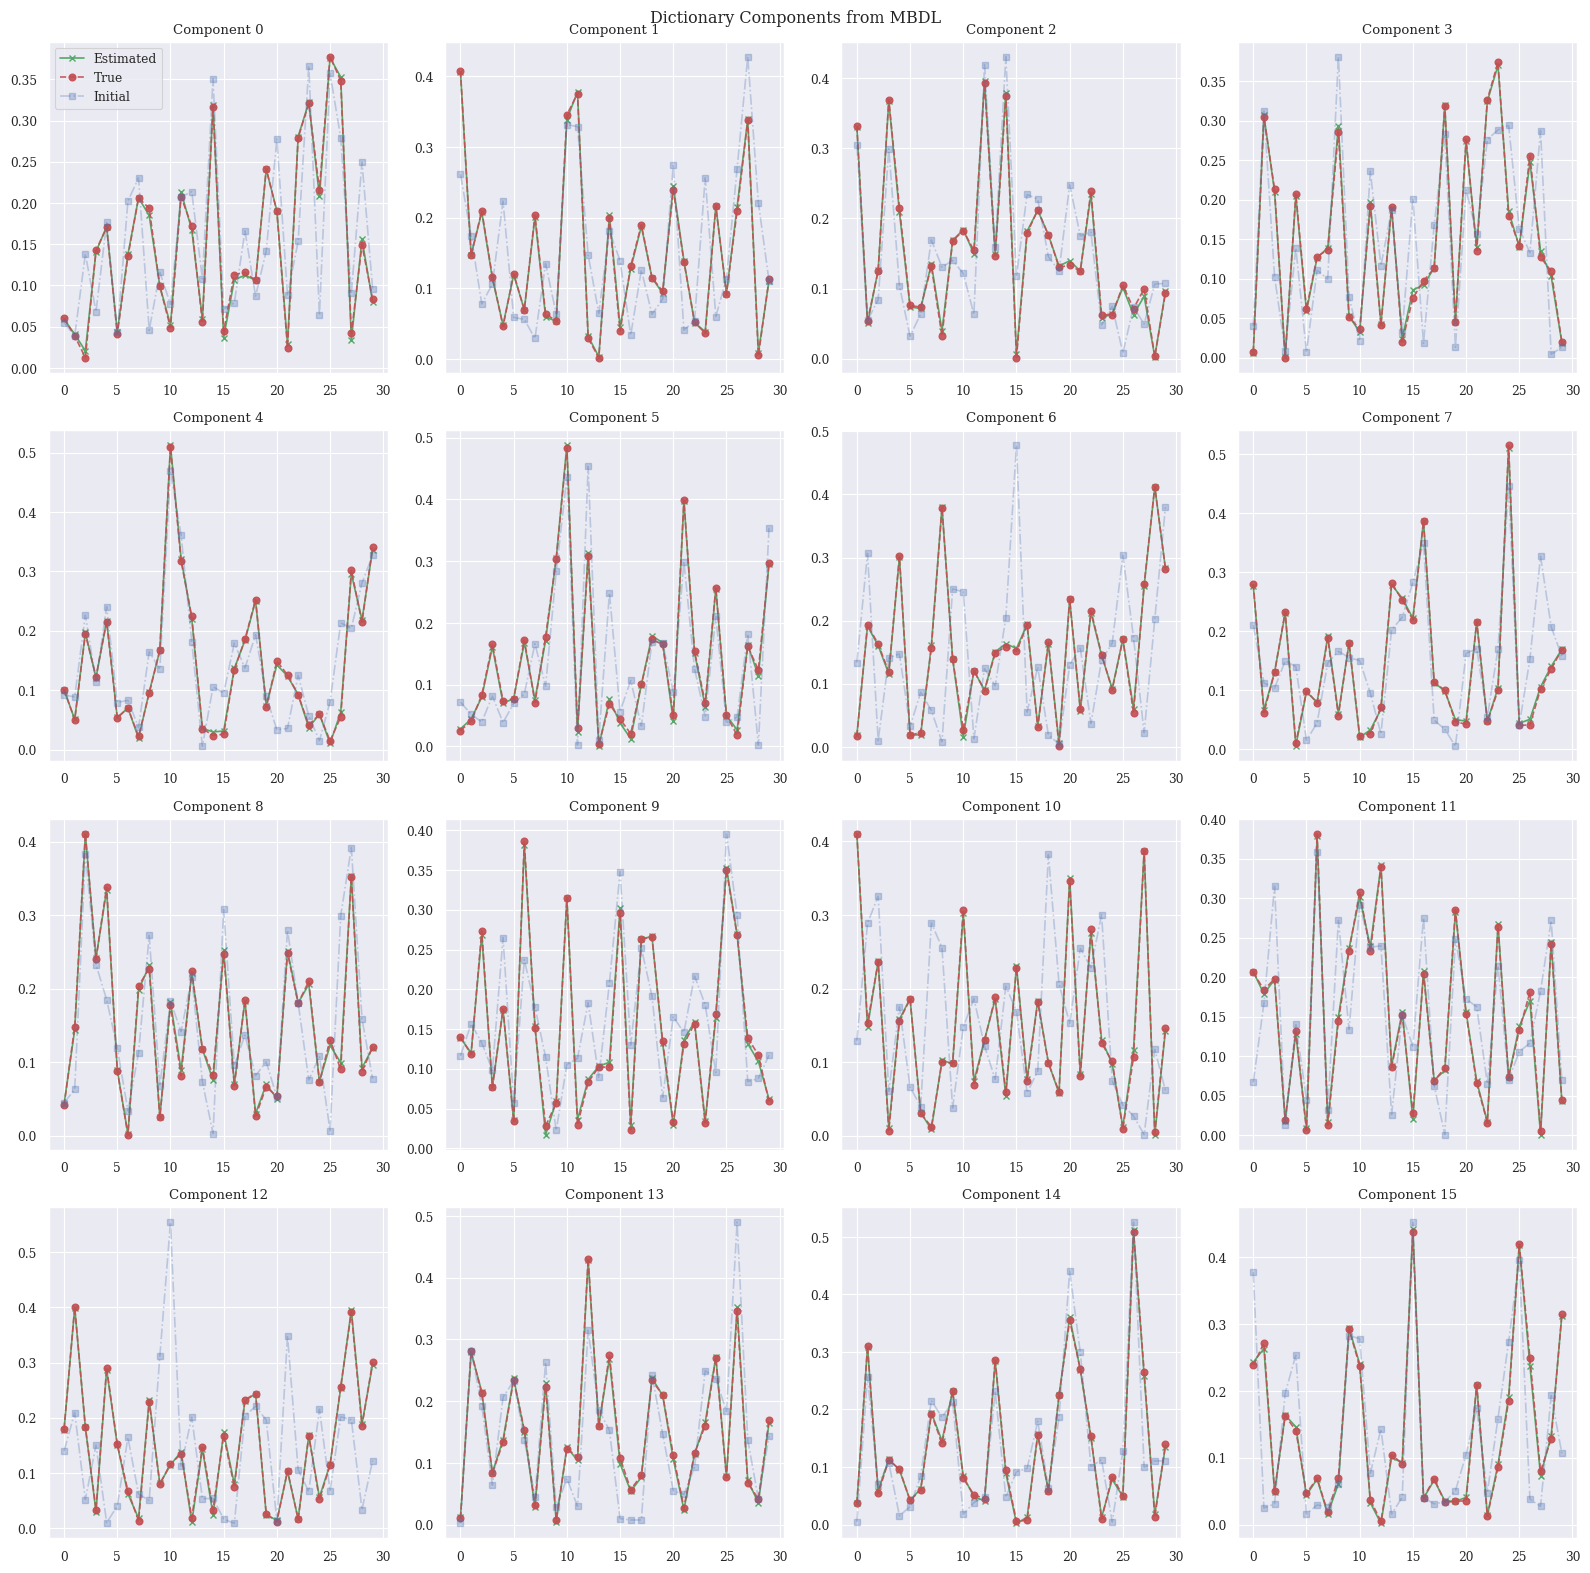

In [29]:
# Plot the dictionary
D_est_realigned_mb = synthetic_dict_mbdl.components_[positions_mb]
W_init_realigned_mb = W_init[positions_mb]
n_rows = 4
n_cols = D.shape[0] // n_rows
fig, ax = plt.subplots(n_rows, n_cols, figsize=(4*n_rows, 4*n_cols))
ax = ax.ravel()
for i in range(D.shape[0]):
    ax[i].plot(np.abs(D_est_realigned_mb[i]), label='Estimated', c='g', linestyle='-', marker='x')
    ax[i].plot(np.abs(D[i]), label='True', c='r', linestyle='--', marker='o', alpha=0.9)
    ax[i].plot(np.abs(W_init_realigned_mb[i]), label='Initial', c='b', linestyle='-.', marker='s', alpha=0.3)
    # ax[i].plot(D[i], label='True')
    # ax[i].plot(W_init_realigned[i], label='KMeans')
    ax[i].set_title(f'Component {i}')
ax[0].legend()
fig.suptitle('Dictionary Components from MBDL')
fig.tight_layout()
fig.show()

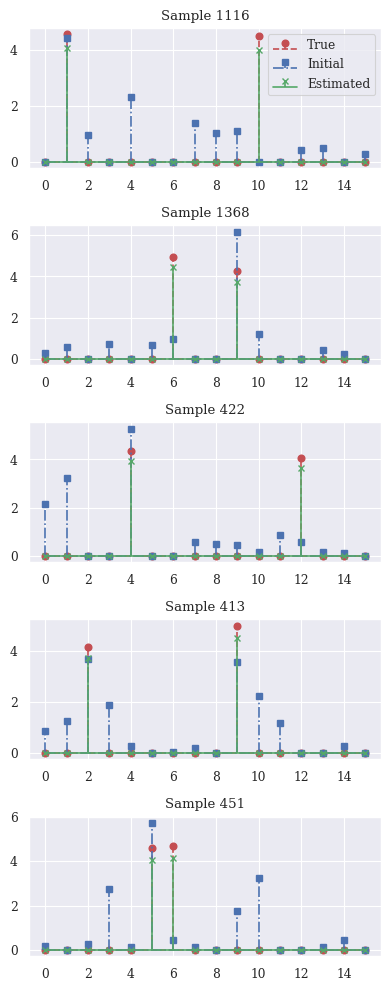

In [30]:
true_Z = Z.numpy()
fig, ax = plt.subplots(5, 1, figsize=(4, 10))
ax = visualize_latents(true_Z, ax=ax, seed=42, linefmt='r--', markerfmt='ro', basefmt='r--', label='True')
ax = visualize_latents(Z_init[:, positions_mb], ax=ax, seed=42, linefmt='b-.', markerfmt='bs', basefmt='b-.', label='Initial')
ax = visualize_latents(Z_est_mb[:, positions_mb], ax=ax, seed=42, linefmt='g-', markerfmt='gx', basefmt='g-', label='Estimated')

ax[0].legend()
fig.tight_layout()
fig.show()

In [31]:
zsim = compute_similarity(torch.abs(torch.from_numpy(true_Z)), torch.abs(torch.from_numpy(Z_est_mb[:, positions_mb])))
print(f"Zsim: {zsim:0.2f}")
dsim = compute_similarity(torch.abs(D), torch.abs(torch.from_numpy(synthetic_dict_mbdl.components_[positions_mb])))
print(f"Dsim: {dsim:0.2f}")

Zsim: 1.00
Dsim: 1.00
